In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import random
import os

In [2]:
# Load .bil file
input_folder = 'C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Cropped Berry/'
output_folder = 'C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/'  # Folder to save patches
os.makedirs(output_folder, exist_ok=True)

bil_file = input_folder + 'Good Blueberry 169-210-FromSelection-ConvertFormat.bil'  # Update this with your file path

# Read the .bil file
with rasterio.open(bil_file) as src:
    bands = src.read()  # Shape: (bands, height, width)
    profile = src.profile  # Get metadata profile for saving patches

# Check the data
print(f'Bands: {bands.shape[0]}')
print(f'Height: {bands.shape[1]}')
print(f'Width: {bands.shape[2]}')




c:\Users\zarin\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Bands: 462
Height: 1518
Width: 1351


In [3]:
# Set patch size
SIZE = 220  # Choose the patch size, e.g., 220x220

# Loop through the image data to cut out patches and save
patch_count = 0
patch_files = []  # Store file paths for plotting
for y in range(0, bands.shape[1], SIZE):  # Iterate over height
    for x in range(0, bands.shape[2], SIZE):  # Iterate over width
        # Extract a patch from all bands
        patch = bands[:, y:y+SIZE, x:x+SIZE]  # Shape: (bands, SIZE, SIZE)
        if patch.shape[1] == SIZE and patch.shape[2] == SIZE:  # Ensure full patch size
            patch_count += 1
            patch_filename = f'patch_{patch_count:04d}.bil'
            patch_path = os.path.join(output_folder, patch_filename)
            
             # Update profile for the patch
            patch_profile = profile.copy()
            patch_profile.update({
                'height': SIZE,
                'width': SIZE,
                'transform': rasterio.windows.transform(
                    rasterio.windows.Window(x, y, SIZE, SIZE), src.transform
                )
            })
            # Write the patch as .bil
            with rasterio.open(patch_path, 'w', **patch_profile) as dst:
                dst.write(patch)
                
            patch_files.append(patch_path)  # Save patch path for plotting

print(f'Saved {patch_count} patches as .bil files in {output_folder}')


c:\Users\zarin\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:327: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Saved 36 patches as .bil files in C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/


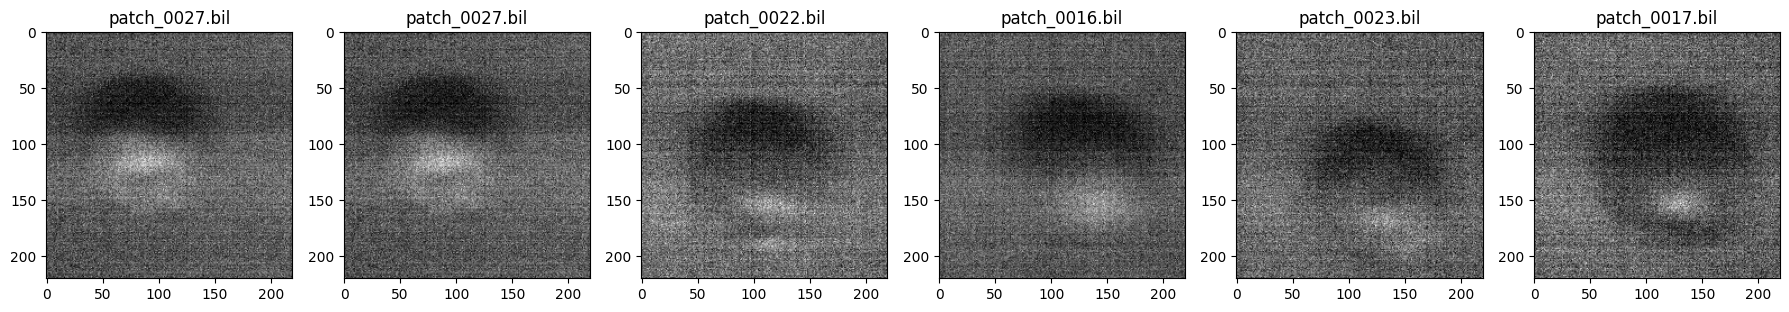

In [4]:
# Plot a few random patches
num_samples_to_display = 6
f = plt.figure(figsize=(18, 3))
ax = f.subplots(1, num_samples_to_display)

for i in range(num_samples_to_display):
    random_patch_path = random.choice(patch_files)  # Choose a random patch file
    with rasterio.open(random_patch_path) as patch_src:
        patch_data = patch_src.read(1)  # Read the first band for visualization
    
    ax[i].imshow(patch_data, cmap='gray')
    ax[i].set_title(os.path.basename(random_patch_path))

plt.tight_layout()
plt.show()

In [20]:
pip install spectral numpy opencv-python opencv-python-headless



   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.8 MB 3.1 MB/s eta 0:00:12
   -- ------------------------------------- 2.4/38.8 MB 4.8 MB/s eta 0:00:08
   ----- ---------------------------------- 5.2/38.8 MB 7.6 MB/s eta 0:00:05
   --------- ------------------------------ 9.2/38.8 MB 10.4 MB/s eta 0:00:03
   ------------- -------------------------- 13.1/38.8 MB 12.3 MB/s eta 0:00:03
   ----------------- ---------------------- 16.8/38.8 MB 13.1 MB/s eta 0:00:02
   -------------------- ------------------- 19.4/38.8 MB 13.5 MB/s eta 0:00:02
   ----------------------- ---------------- 22.8/38.8 MB 13.4 MB/s eta 0:00:02
   -------------------------- ------------- 25.4/38.8 MB 13.4 MB/s eta 0:00:01
   ---------------------------- ----------- 28.0/38.8 MB 13.6 MB/s eta 0:00:01
   ------------------------------- -------- 30.9/38.8 MB 13.4 MB/s eta 0:00:


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
pip install spectral numpy opencv-python



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:



import numpy as np
import spectral.io.envi as envi
import cv2
import os

def load_hyperspectral_image(file_path):
    """Load hyperspectral image and header."""
    hdr_path = file_path.replace(".bil", ".hdr")
    img = envi.open(hdr_path, file_path)
    return img.load(), img.metadata

def contour_and_mask(data, threshold_band, min_contour_area=500):
    """
    Perform contouring and masking on hyperspectral data.

    Parameters:
        data (numpy.ndarray): Hyperspectral image cube (bands, height, width).
        threshold_band (int): Band to use for contour detection.
        min_contour_area (int): Minimum area for valid contours.

    Returns:
        numpy.ndarray: Masked hyperspectral image cube.
    """
    band_image = data[threshold_band, :, :]  # Select a specific band
    band_image = np.squeeze(band_image)  # Ensure it's a 2D array
    normalized = cv2.normalize(band_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Ensure the image is grayscale (single-channel uint8)
    if len(normalized.shape) != 2:
        raise ValueError("Normalized band image is not a valid grayscale image")

    # Apply thresholding
    _, binary_image = cv2.threshold(normalized, 50, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary_image)

    # Draw valid contours on the mask
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to all bands
    mask = mask > 0
    masked_data = data * mask[None, :, :]
    
    return masked_data

def save_bil_and_hdr(output_bil_path, output_hdr_path, data, metadata):
    """Save the masked hyperspectral data to .bil and .hdr files."""
    # Save the masked data as a .bil file (raw binary)
    with open(output_bil_path, 'wb') as f:
        data.tofile(f)
    
    # Save the header file
    metadata['samples'] = data.shape[2]  # width (columns)
    metadata['lines'] = data.shape[1]    # height (rows)
    metadata['bands'] = data.shape[0]    # number of bands
    metadata['data type'] = 4            # ENVI datatype for float32 (this could vary)
    
    with open(output_hdr_path, 'w') as f:
        for key, value in metadata.items():
            f.write(f'{key} = {value}\n')

# File paths
bil_path = "C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/patch_0009.bil"
hdr_path = bil_path.replace(".bil", ".hdr")
output_bil_path = "C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/patch_0009_masked.bil"
output_hdr_path = output_bil_path.replace(".bil", ".hdr")

# Parameters
threshold_band = 50  # Adjust this band based on your data
min_contour_area = 500  # Minimum area for valid contours

# Process the file
print(f"Processing {bil_path}...")
data, metadata = load_hyperspectral_image(bil_path)
masked_data = contour_and_mask(data, threshold_band, min_contour_area)

# Save as .bil and .hdr files
save_bil_and_hdr(output_bil_path, output_hdr_path, masked_data, metadata)

print(f"Masked file saved to {output_bil_path}")



Processing C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/patch_0009.bil...
Masked file saved to C:/Users/zarin/OneDrive/Desktop/NSU/12th Semester/CSE 499/Datasets/Blueberry/Patches/patch_0009_masked.bil
